<a href="https://colab.research.google.com/github/bj-bestjung/Onjira-Portfolio/blob/main/Using_XGBClassifier_model_to_predict_the_Buy_Sell_signal_of_DXY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance xgboost

# Fetch DXY data from Yahoo in real-time

In [2]:
import yfinance as yf
dxy = yf.download("DX-Y.NYB", start="2020-01-01", interval="1d")
print(dxy.tail())

/tmp/ipython-input-2-3339031342.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", start="2020-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open   Volume
Ticker       DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB DX-Y.NYB
Date                                                           
2025-07-07  97.480003  97.669998  96.889999  96.959999        0
2025-07-08  97.510002  97.839996  97.180000  97.360001        0
2025-07-09  97.470001  97.750000  97.459999  97.550003        0
2025-07-10  97.650002  97.919998  97.269997  97.440002        0
2025-07-11  97.791000  97.893997  97.555000  97.572998        0


# Import database

In [4]:
# Real-Time DXY Buy/Sell Signal Using Yahoo Finance Data
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load DXY data from Yahoo Finance
dxy = yf.download("DX-Y.NYB", start="2020-01-01", interval="1d")
dxy = dxy.reset_index()[['Date', 'Open', 'High', 'Low', 'Close']]
#dxy.rename(columns={'Close': 'Close*'}, inplace=True)
print(dxy)

/tmp/ipython-input-4-2080023164.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", start="2020-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Price        Date       Open       High        Low      Close
Ticker              DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB
0      2020-01-02  96.480003  96.870003  96.430000  96.849998
1      2020-01-03  96.790001  97.110001  96.709999  96.839996
2      2020-01-06  96.900002  96.900002  96.540001  96.669998
3      2020-01-07  96.650002  97.089996  96.620003  96.980003
4      2020-01-08  96.830002  97.330002  96.820000  97.300003
...           ...        ...        ...        ...        ...
1385   2025-07-07  96.959999  97.669998  96.889999  97.480003
1386   2025-07-08  97.360001  97.839996  97.180000  97.510002
1387   2025-07-09  97.550003  97.750000  97.459999  97.470001
1388   2025-07-10  97.440002  97.919998  97.269997  97.650002
1389   2025-07-11  97.572998  97.893997  97.555000  97.792000

[1390 rows x 5 columns]


In [5]:
dxy_ticker = yf.Ticker('DX-Y.NYB')

In [6]:
dxy = dxy_ticker.history(start="2020-01-01", interval="1d")

In [7]:
dxy = dxy.reset_index()[['Date', 'Open', 'High', 'Low', 'Close']]

In [8]:
print(dxy)

                          Date       Open       High        Low      Close
0    2020-01-02 00:00:00-05:00  96.480003  96.870003  96.430000  96.849998
1    2020-01-03 00:00:00-05:00  96.790001  97.110001  96.709999  96.839996
2    2020-01-06 00:00:00-05:00  96.900002  96.900002  96.540001  96.669998
3    2020-01-07 00:00:00-05:00  96.650002  97.089996  96.620003  96.980003
4    2020-01-08 00:00:00-05:00  96.830002  97.330002  96.820000  97.300003
...                        ...        ...        ...        ...        ...
1385 2025-07-07 00:00:00-04:00  96.959999  97.669998  96.889999  97.480003
1386 2025-07-08 00:00:00-04:00  97.360001  97.839996  97.180000  97.510002
1387 2025-07-09 00:00:00-04:00  97.550003  97.750000  97.459999  97.470001
1388 2025-07-10 00:00:00-04:00  97.440002  97.919998  97.269997  97.650002
1389 2025-07-11 00:00:00-04:00  97.572998  97.893997  97.555000  97.790001

[1390 rows x 5 columns]


# Feature

In [9]:
# Feature engineering (manual indicators)
dxy['EMA50'] = dxy['Close'].ewm(span=50, adjust=False).mean()
dxy['EMA200'] = dxy['Close'].ewm(span=200, adjust=False).mean()
delta = dxy['Close'].diff()
# Ensure gain and loss are 1-dimensional numpy arrays
gain = np.where(delta > 0, delta, 0).flatten()
loss = np.where(delta < 0, -delta, 0).flatten()
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
# Handle division by zero if avg_loss is zero to avoid inf in RSI calculation
rs = np.where(avg_loss == 0, np.nan, avg_gain / avg_loss)
dxy['RSI'] = 100 - (100 / (1 + rs))
ema_12 = dxy['Close'].ewm(span=12, adjust=False).mean()
ema_26 = dxy['Close'].ewm(span=26, adjust=False).mean()
dxy['MACD'] = ema_12 - ema_26
dxy['MACD_signal'] = dxy['MACD'].ewm(span=9, adjust=False).mean()
sma20 = dxy['Close'].rolling(window=20).mean()
std20 = dxy['Close'].rolling(window=20).std()
dxy['BB_upper'] = sma20 + (2 * std20)
dxy['BB_lower'] = sma20 - (2 * std20)

# Data preparation

In [10]:
# Label creation
dxy['Target'] = (dxy['Close'].shift(-1) > dxy['Close']).astype(int)
#dxy.dropna(inplace=True)

# Check shape before dropping NaNs

In [11]:
print(f"Shape before dropna: {dxy.shape}")

Shape before dropna: (1390, 13)


# Check for missing values before dropping NaNs

In [12]:
# Check for missing values before dropping NaNs
print("Missing values before dropna:")
print(dxy.isnull().sum())

Missing values before dropna:
Date            0
Open            0
High            0
Low             0
Close           0
EMA50           0
EMA200          0
RSI            13
MACD            0
MACD_signal     0
BB_upper       19
BB_lower       19
Target          0
dtype: int64


In [13]:
dxy.dropna(inplace=True)

# Check shape after dropping NaNs

In [14]:
print(f"Shape after dropna: {dxy.shape}")

Shape after dropna: (1371, 13)


# Train/Test split

In [15]:
# Train/Test split
features = ['Open', 'High', 'Low', 'Close', 'EMA50', 'EMA200', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower']
X = dxy[features]
y = dxy['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Training XGBoost model

In [16]:
# Train XGBoost model
import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
#X_train = model.fit_transform(X_train)
#X_test = model.fit_transform(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Predict & Evaluate

In [17]:
# Predict & Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.2%}")

✅ Model Accuracy: 53.09%


# Plot Buy/Sell for last 5 years

BUY signal: RSI < 30 AND MACD < MACD Signal AND EMA3 < EMA10 → บ่งชี้ Oversold + Momentum ต่ำ + Downtrend

SELL signal: RSI > 70 AND MACD > MACD Signal AND EMA3 > EMA10 → บ่งชี้ Overbought + Momentum สูง + Uptrend

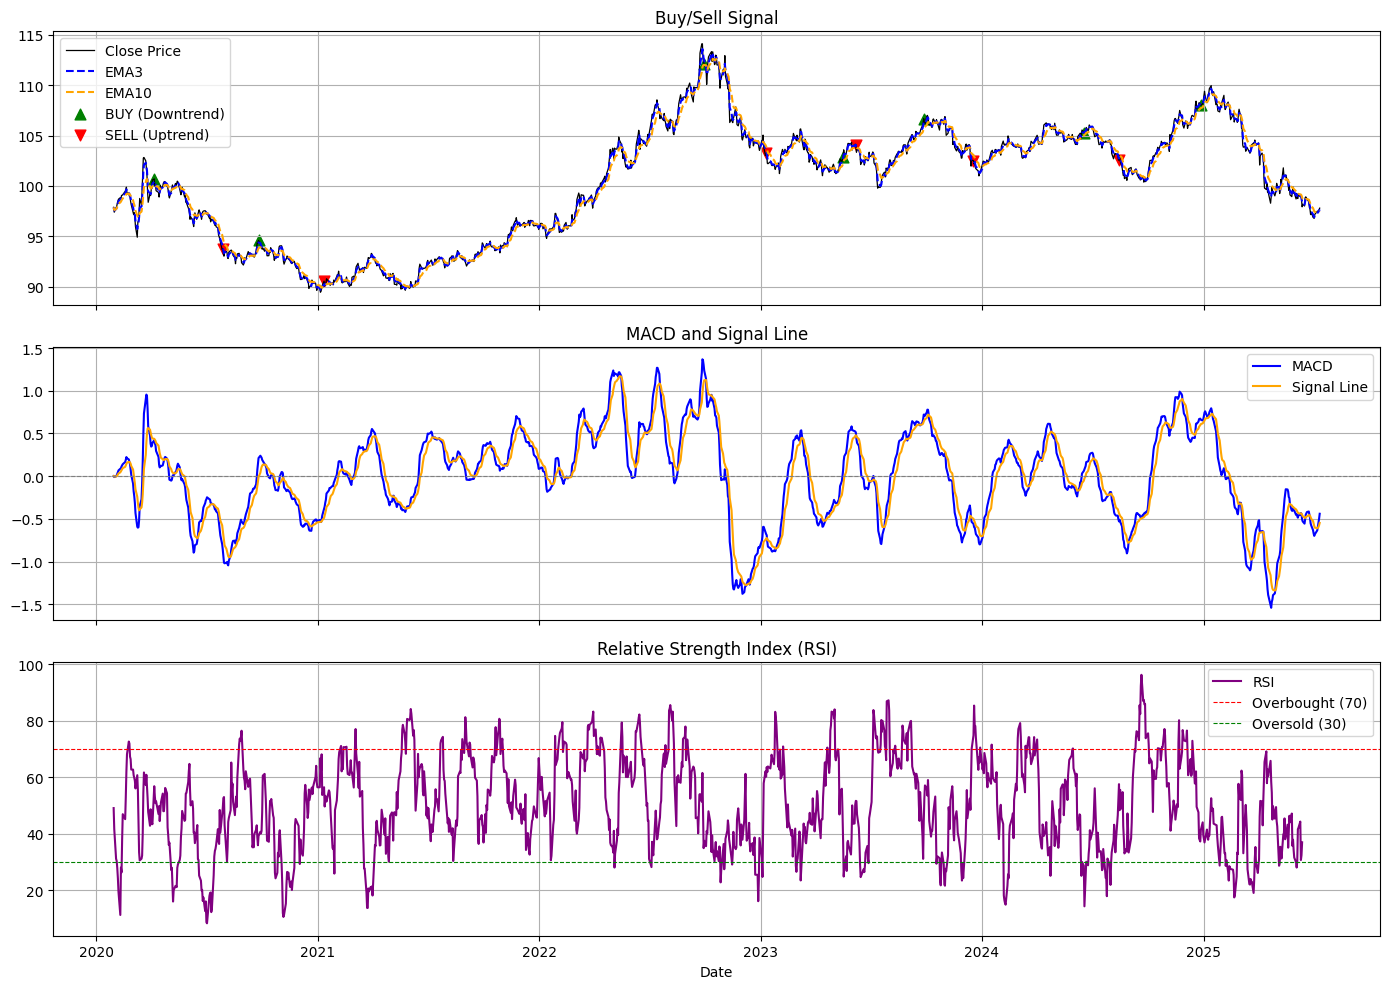

In [18]:
# @title
# plot 5-day interval Buy/Sell signal for last 5 years
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# คำนวณ EMA3 และ EMA10 เพื่อตรวจเทรนด์
dxy['EMA3'] = dxy['Close'].ewm(span=3).mean()
dxy['EMA10'] = dxy['Close'].ewm(span=10).mean()
#dxy['EMA100'] = dxy['Close'].ewm(span=100).mean()

# MACD
ema_12 = dxy['Close'].ewm(span=12).mean()
ema_26 = dxy['Close'].ewm(span=26).mean()
dxy['MACD'] = ema_12 - ema_26
dxy['MACD_signal'] = dxy['MACD'].ewm(span=9).mean()

#RSI (14 days)
delta = dxy['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
dxy['RSI'] = 100 - (100 / (1 + rs))

# Signal with strict filter
dxy['Signal'] = 'Hold'
dxy.loc[
    (dxy['RSI'] < 30) &
    (dxy['MACD'] < dxy['MACD_signal']) &
    (dxy['EMA3'] < dxy['EMA10']),
#    (dxy['Close'] > dxy['EMA100']),
    'Signal'
] = 'Buy'

dxy.loc[
    (dxy['RSI'] > 70) &
    (dxy['MACD'] > dxy['MACD_signal']) &
    (dxy['EMA3'] > dxy['EMA10']),
#    (dxy['Close'] < dxy['EMA100']),
    'Signal'
] = 'Sell'

# Trend: ถ้า EMA3 > EMA10 ถือว่า "ขึ้น" → ให้ SELL
# ถ้า EMA3 < EMA10 ถือว่า "ลง" → ให้ BUY
#Combined Signal
#dxy['Signal'] = 'Hold'
#dxy.loc[(dxy['RSI'] < 30) & (dxy['MACD'] < dxy['MACD_signal']) & (dxy['EMA50'] < dxy['EMA200']), 'Signal'] = 'Buy'
#dxy.loc[(dxy['RSI'] > 70) & (dxy['MACD'] > dxy['MACD_signal']) & (dxy['EMA50'] > dxy['EMA200']), 'Signal'] = 'Sell'

# ปรับเงื่อนไขให้ออกสัญญาณมากขึ้น
#dxy['Signal'] = 'Hold'
#dxy.loc[
#    ((dxy['RSI'] < 40) & (dxy['EMA3'] < dxy['EMA10'])) |
#    ((dxy['MACD'] < dxy['MACD_signal']) & (dxy['EMA3'] < dxy['EMA10']))
#, 'Signal'] = 'Buy'

#dxy.loc[
#    ((dxy['RSI'] > 60) & (dxy['EMA3'] > dxy['EMA10'])) |
#    ((dxy['MACD'] > dxy['MACD_signal']) & (dxy['EMA3'] > dxy['EMA10']))
#, 'Signal'] = 'Sell'

# Confirmed signal: Buy → Sell → Buy logic
dxy['ConfirmedSignal'] = 'Hold'
holding = False

for i in range(len(dxy)):
    row = dxy.iloc[i]
    if not holding and row['Signal'] == 'Buy':
        dxy.at[i, 'ConfirmedSignal'] = 'Buy'
        holding = True

    elif holding and row['Signal'] == 'Sell':
        dxy.at[i, 'ConfirmedSignal'] = 'Sell'
        holding = False

# Filter every 5th day (already 5-day spaced data)
#dxy_5d = dxy.iloc[::5].copy()
buy_signals = dxy[dxy['ConfirmedSignal'] == 'Buy']
sell_signals = dxy[dxy['ConfirmedSignal'] == 'Sell']


# Step 4: Plot
# Figure and Subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Figure and Signal
axs[0].plot(dxy['Date'], dxy['Close'], label='Close Price', color='Black', linewidth=0.9)
axs[0].plot(dxy['Date'], dxy['EMA3'], label='EMA3', linestyle='--', color='blue')
axs[0].plot(dxy['Date'], dxy['EMA10'], label='EMA10', linestyle='--', color='orange')
#axs[0].plot(dxy['Date'], dxy['EMA100'], label='EMA100', linestyle='--', color='orange')
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], label='BUY (Downtrend)', marker='^', color='green', s=60)
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], label='SELL (Uptrend)', marker='v', color='red', s=60)
axs[0].set_title("Buy/Sell Signal")
axs[0].legend()
axs[0].grid(True)

# Plot MACD
axs[1].plot(dxy['Date'], dxy['MACD'], label='MACD', color='blue')
axs[1].plot(dxy['Date'], dxy['MACD_signal'], label='Signal Line', color='orange')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axs[1].set_title('MACD and Signal Line')
axs[1].legend()
axs[1].grid(True)

# Plot RSI
axs[2].plot(dxy['Date'], dxy['RSI'], label='RSI', color='purple')
axs[2].axhline(70, color='red', linestyle='--', linewidth=0.8, label='Overbought (70)')
axs[2].axhline(30, color='green', linestyle='--', linewidth=0.8, label='Oversold (30)')
axs[2].set_title('Relative Strength Index (RSI)')
axs[2].legend()
axs[2].grid(True)

# Layout
plt.xlabel("Date")
plt.tight_layout()
plt.show()